# **PARAMETER FITTING DETAILED EXAMPLE**

This provides a detailed example of parameter fitting using the python-based tool ``SBstoat``. 
Details about the tool can be found at in this [github repository](https://github.com/sys-bio/SBstoat).

# Preliminaries

In [1]:
IS_COLAB = True

In [2]:
if IS_COLAB:
    !pip install -q SBstoat
    !pip install -q tellurium
    pass

In [3]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request # use this library to download file from GitHub
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

# Constants and Helper Functions

In [4]:
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, 

In [5]:
def plotTS(ts, title=""):
    """
    Plots columns in a timeseries.
    
    Parameters
    ----------
    ts: NamedTimeseries
    """
    p = plt.plot(ts[TIME], ts[ts.colnames])
    _ = plt.legend(p, ts.colnames, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = plt.title(title)

# Running SBstoat

``SBstoat`` is a python package intended to simplify the programmatic aspects of fitting. The package provides handles the programming details
of the interactions between the optimization codes (``lmfit``) and ``tellurium`` simulations.

The required inputs to ``SBstoat`` are:
- the model for which parameter values are being estimated;
- observational data; and
- specification of the parameters, their value ranges, and initial values.

For the linear pathway model, we ``LINEAR_PATHWAY_MODEL`` and ``LINEAR_PATHWAY_DF`` for the model and data, respectively.
The description of the paarameters is done using a python dictionary, as shown below.

In [6]:
# Name, minimal value, initial value, and maximum value of each parameter
LINEAR_PATHWAY_PARAMETERS = [
    SBstoat.Parameter("k1", lower=1, value=50, upper=100),
    SBstoat.Parameter("k2", lower=1, value=50, upper=100),
    SBstoat.Parameter("k3", lower=1, value=50, upper=100),
    SBstoat.Parameter("k4", lower=1, value=50, upper=100),
]

The python class ``ModelFitter`` does fitting for ``SBstoat``. Details of using this can be found below.

In [7]:
?ModelFitter

Init signature: ModelFitter(*args, **kwargs)
Docstring:      Cross validation for ModelFitter
Init docstring:
Constructs estimates of parameter values.

Parameters
----------
endTime: float
    end time for the simulation
modelSpecification: ExtendedRoadRunner/str
    roadrunner model or antimony model
observedData: NamedTimeseries/str
    str: path to CSV file
parametersToFit: list-str/SBstoat.Parameter/None
    parameters in the model that you want to fit
    if None, no parameters are fit
selectedColumns: list-str
    species names you wish use to fit the model
    default: all columns in observedData
parameterLowerBound: float
    lower bound for the fitting parameters
parameterUpperBound: float
    upper bound for the fitting parameters
logger: Logger
fitterMethods: str/list-str/list-OptimizerMethod
    method used for minimization in fitModel
numFitRepeat: int
    number of times fitting is repeated for a method
bootstrapMethods: str/list-str/list-OptimizerMethod
    method used 

In [8]:
fitter = ModelFitter(LINEAR_PATHWAY_MODEL, 
                     NamedTimeseries(dataframe=LINEAR_PATHWAY_DF), 
                     parametersToFit=LINEAR_PATHWAY_PARAMETERS)
fitter.fitModel()

``SBstoat`` provides a textual report of the results of the fit.

In [9]:
print(fitter.reportFit())

[[Variables]]
    k1:  1.0135373265988252
    k2:  2.1581300354936723
    k3:  3.0793402161035726
    k4:  4.280400008847035
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 500
    # variables        = 4
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


The report is in three sections.

The first section contains measures of the fit quality. The most commonly used measures are chi-square and reduced chai-square.
We want both of these to be "small", although small is relative.
These measures are most useful when comparing different fit results.

The "Variables" section gives parameter estimates. We se that the estimates obtained are fairly close to
the true values in the original models.

The final section provides information about the relationships between parameter estimates. This can be useful
in models where the structure of the model makes it difficult to separate one parameter from another.
In these cases, there will be a large correlation between parameter (absolute) parameter values.

``SBstoat`` provides many plots to aid in understanding the fitting results.
You can see these by typing in a Jupyter code cell ``fitter.pl`` and then pressing the tab key.
Arguably the most useful is ``plotFitAll``, which, for each floating species (column in observed data), plots the fitted and observed values.
This is shown below.

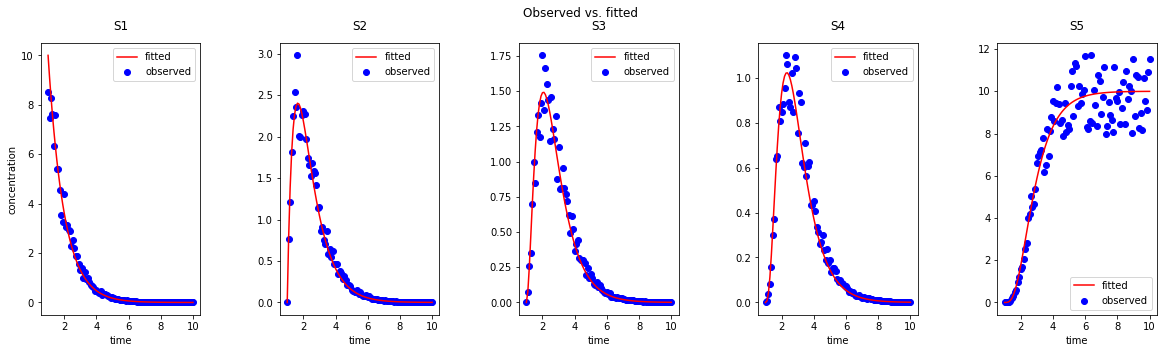

In [10]:
fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

These fits seem to be quite consistent with the observed data, with the possible exception of ``S5``.
In the latter case, there is considerable variability that likely makes a good fit more difficult.

In [11]:
# See the options for plotFitAll
?fitter.plotFitAll

Signature:
fitter.plotFitAll(
    params:lmfit.parameter.Parameters=None,
    numPoint:int=None,
    **kwargs,
)
Docstring:
Plots the fitted with observed data over time.

Parameters
----------

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
    (f) rows of plots
subplotWidthSpace: float
    (f) horizontal space between plo

If you are interested in a more complete analysis of the residuals, use ``plotResidualsAll``.

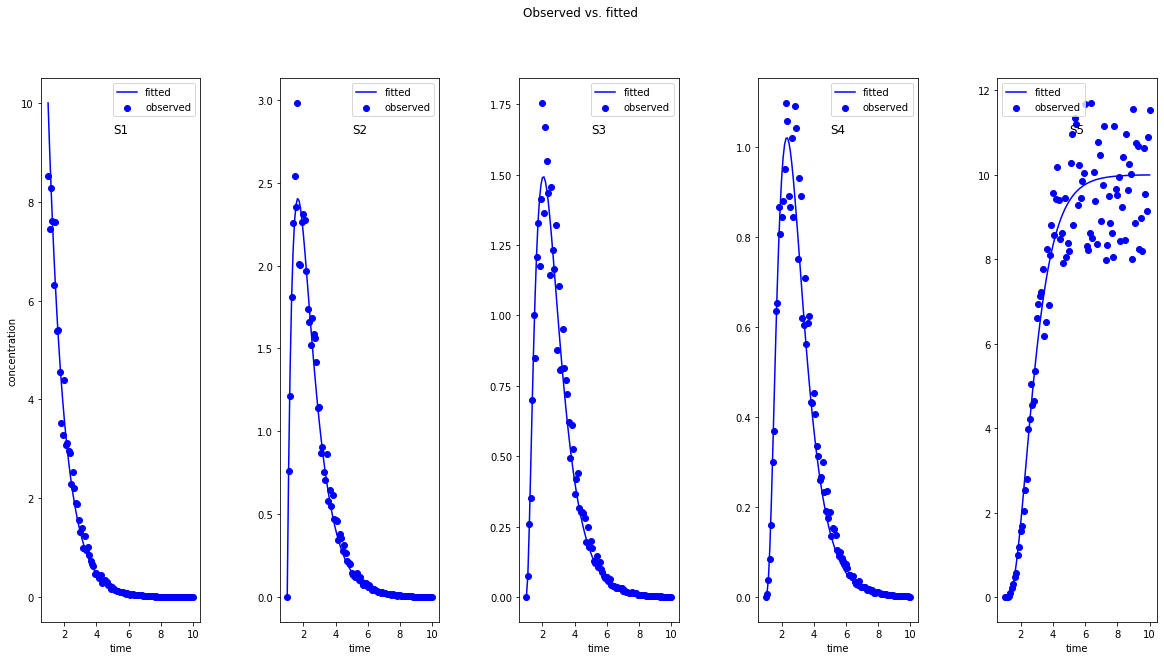

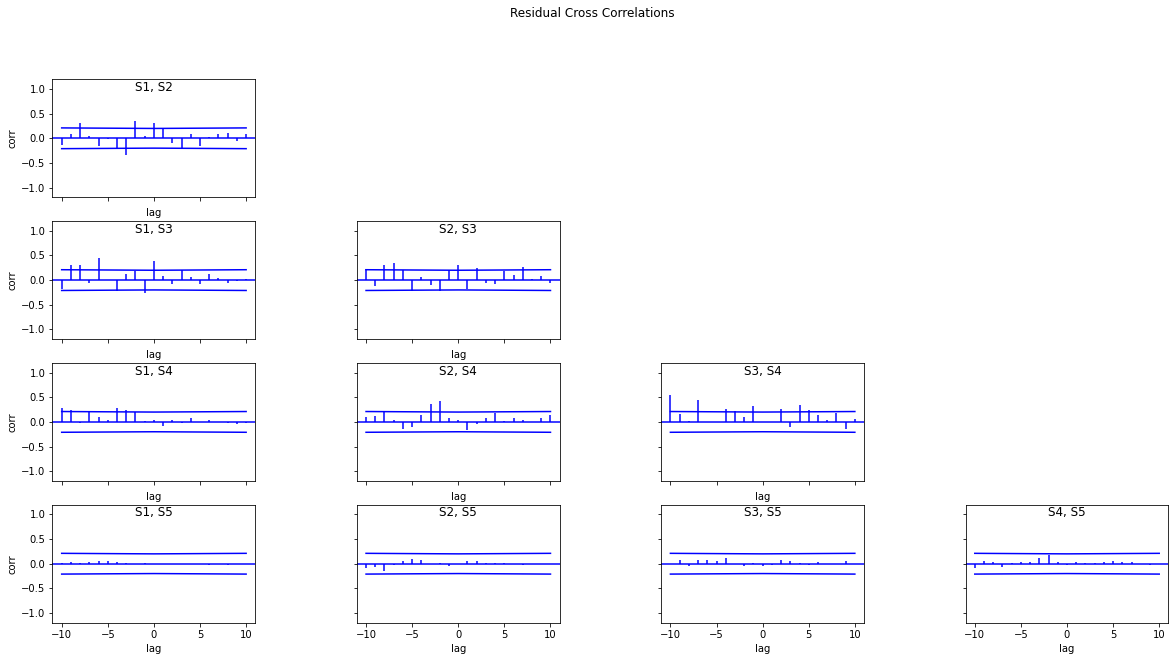

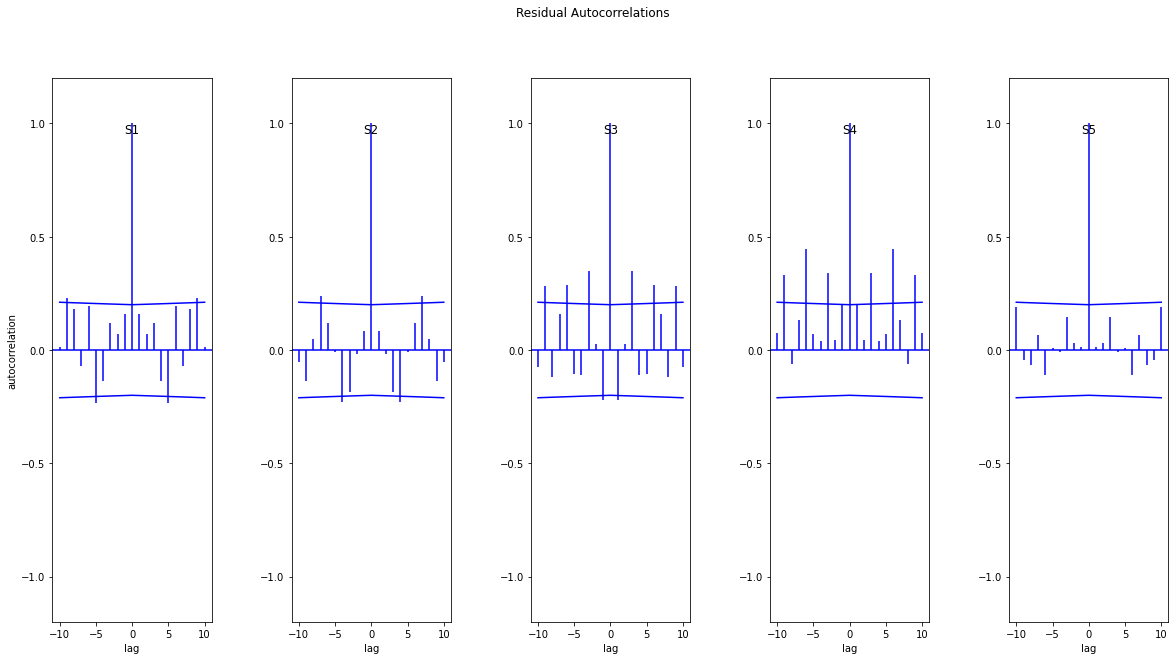

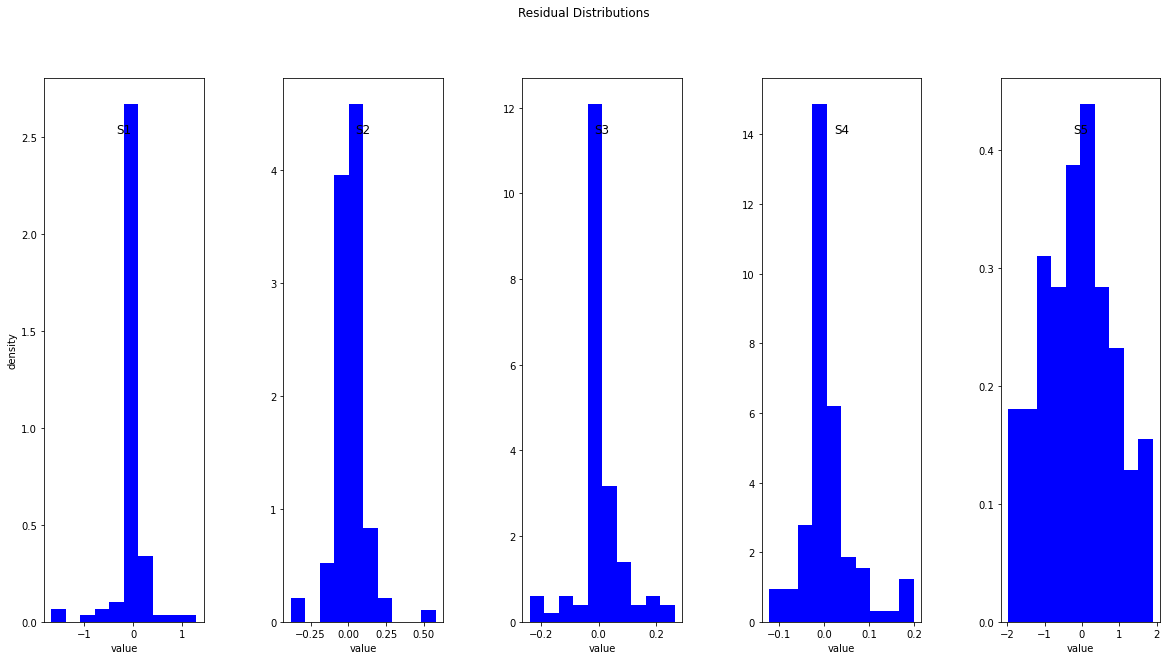

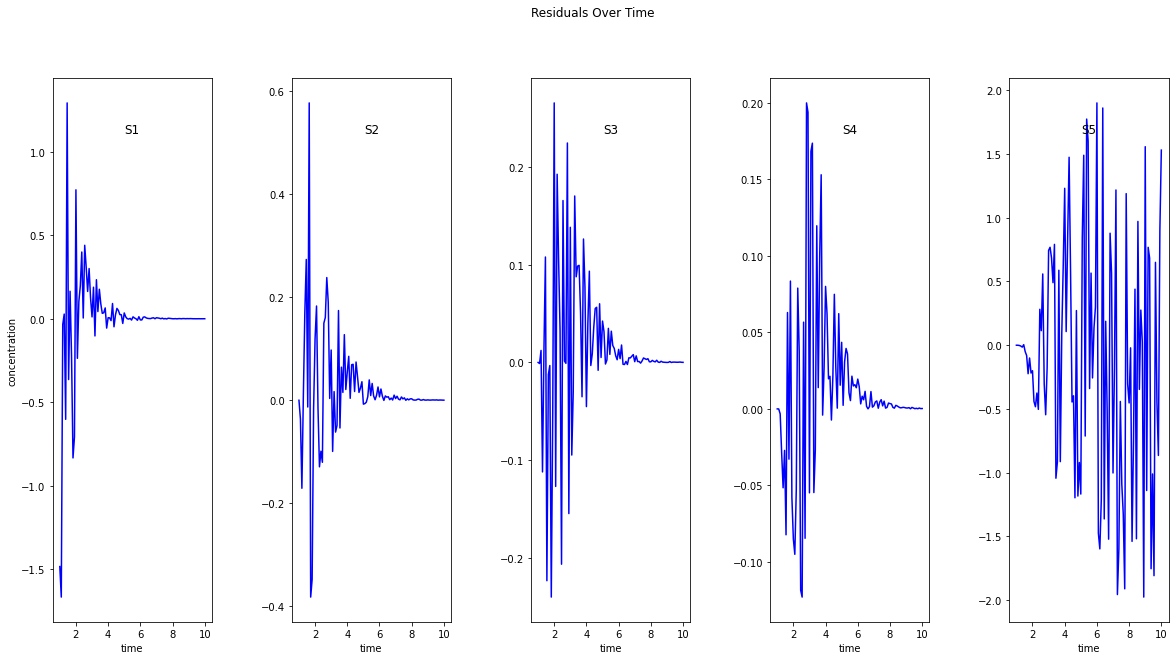

In [12]:
fitter.plotResidualsAll(figsize=(20, 10))

# Workflow for fitting the Linear Pathway Model

Although ``SBstoat`` eliminates the burden of programming details, fitting is often complex.
This is because of the complexity of the fitting surface, as illustrated earlier in this chaper.
This section illustrates how to use ``SBstoat`` to explore complex fitting surfaces.

``SBstoat`` allows you to explore fitting along three dimensions.
1. **Fitting surface**. The fitting surface changes based on the following:
  a. the selection of float species (columns in the observed data) that we attempt to fit;
  b. the time span we fit over
1. **Optimization Algorithms**. As we noted previously, gradient descent is fast, but it only works well for convex fitting surfaces. We might want to try both gradient descent and differential evolution to see which works best for our model. Also, some optimization algorithms are stochastic, and so the search strategy may also choose to run
the same algorithm multiple times. Finally, it may be desirable to do multiple optimizations in succession, using the results of the $n-1$-st to be the starting point for the $n$-th.
1. **Search start & scope**. This refers to the initial values of parameter values and the range of parameter values that are explored.


In the following explorations of the above dimensions of parameter fitting, we use the above workflow that consists of:
1. Select a subset of the observed data based on a specified time span (in this case, just ending time)
1. Construct a fitter for the linear pathway, observed data, columns to consider in fitting, the fitting methods, and parameter ranges/initial values.
1. Fit the model.
1. Print the fitting report.
1. Plot observed and fitted values.

This workflow is encapsulated in the the function ``doFit``.
The arguments of the function have default that reproduce the
results in the previous section.

In [13]:
def doFit(selectedColumns=None, 
          endTime=10, 
          fitterMethods=["differential_evolution", "leastsq"], 
          parametersToFit=LINEAR_PATHWAY_PARAMETERS,
          isTest=False):
    """
    Encapsulates the workflow to fit the linear pathway model.

    Parameters
    ----------
    selectedColumns: list-str
    endTime: int
    fitterMethods: list-str
    parametersToFit: list-SBstoat.Parameter
    isTest: bool
        Test mode

    Returns
    -------
    ModelFitter
    """
    model = te.loada(LINEAR_PATHWAY_MODEL)
    observedTS = NamedTimeseries(dataframe=LINEAR_PATHWAY_DF)
    # Find the last index to use
    lastIdx = len([t for t in observedTS[TIME] if t <= endTime])
    observedTS = observedTS[:lastIdx]
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, observedTS, selectedColumns=selectedColumns, 
                         fitterMethods=fitterMethods, 
                         parametersToFit=parametersToFit)
    fitter.fitModel()
    if not isTest:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return fitter

# TESTS
result = doFit(isTest=True)
assert(isinstance(fitter, ModelFitter))

[[Variables]]
    k1:  1.0135373064383726
    k2:  2.1581301230961936
    k3:  3.079338170563924
    k4:  4.280402027805822
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 500
    # variables        = 4
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


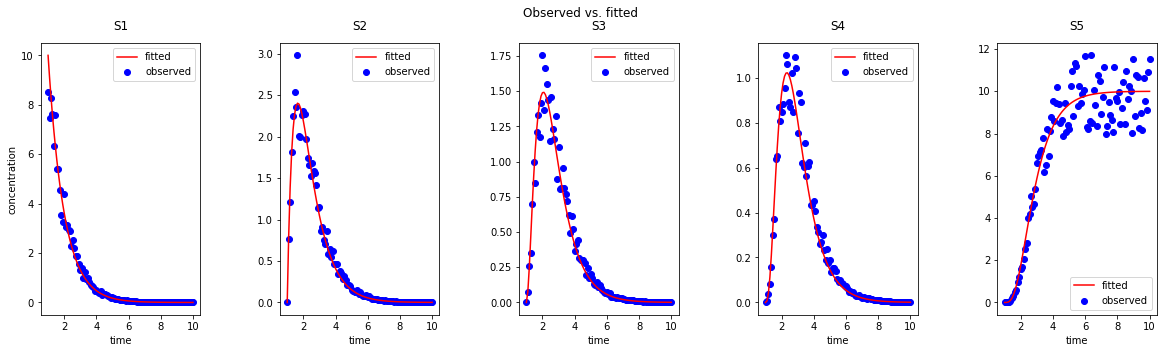

In [14]:
doFit()

## Fitting Surface

We begin by exploring the effect of the fitting surface.

We can control the fitting surface in two ways. The first is by the selection of columns that are matched with observational data.

For example, suppose that we only consider ``S5`` and so the fitting surface is residuals
from fitting ``S5``.

[[Variables]]
    k1:  2.851961837001552
    k2:  2.8532411501732
    k3:  1.0739029389477601
    k4:  2.8520933424977493
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 100
    # variables        = 4
    chi-square         = 90.7507758
    reduced chi-square = 0.94532058
    Akaike info crit   = -1.70531640
    Bayesian info crit = 8.71536435
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k4) = -0.998
    C(k2, k4) = -0.729
    C(k1, k3) = -0.694
    C(k1, k2) =  0.684
    C(k3, k4) =  0.650


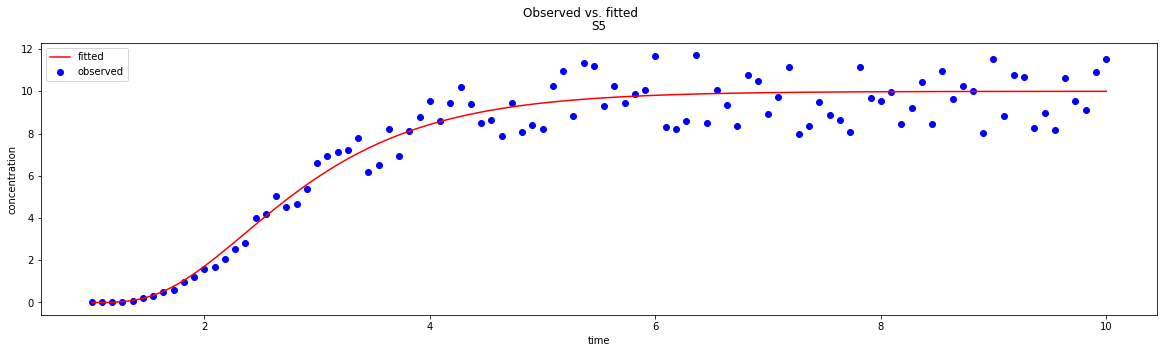

In [15]:
doFit(selectedColumns=["S5"])

We see that we get poor estimates for most of the parameters, something that we can check because we know the true values of the parameters (``k1=1``, ``k2=2``, ``k3=3``, ``k4=4``).

Another consideration is to focus on a subset of the dynamics. Below, we only consider through 2 seconds.

[[Variables]]
    k1:  1.0340913868382917
    k2:  2.093305173775931
    k3:  2.9192466631023417
    k4:  3.8265927798074504
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 60
    # variables        = 4
    chi-square         = 9.99250125
    reduced chi-square = 0.17843752
    Akaike info crit   = -99.5505775
    Bayesian info crit = -91.1731993
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.147
    C(k1, k2) =  0.138


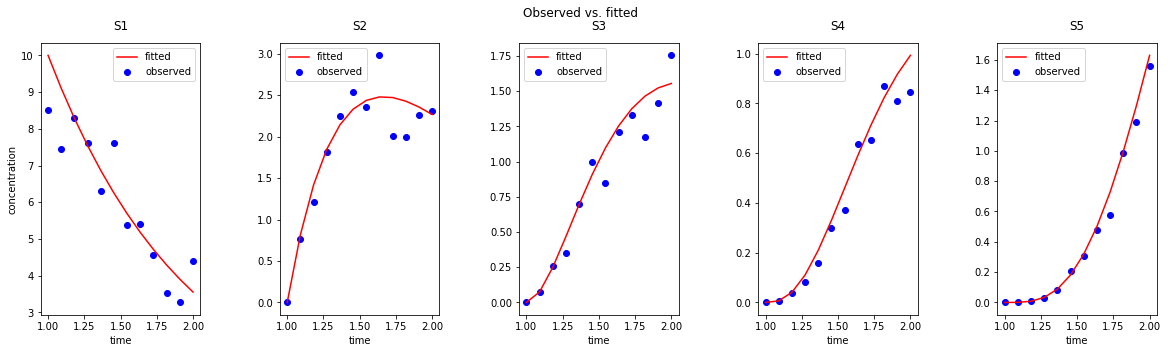

In [16]:
doFit(endTime=2)

This improved the quality of the fit. We see this visually in the above plots and also in the significant reduction in chi-square. A lot of this improvement
is a result of not inluding regions of high variability in observed values for ``S5``.

## Optimization Algorithms

The main consideration here is the choice of optimization algorithms.
Any valid ``method`` for ``lmfit`` can be used, and multiple methods can be used in combination. We illustrate this below.

[[Variables]]
    k1:  1.013537272208723
    k2:  2.1581300220005524
    k3:  3.079339166352762
    k4:  4.280404936773545
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 500
    # variables        = 4
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


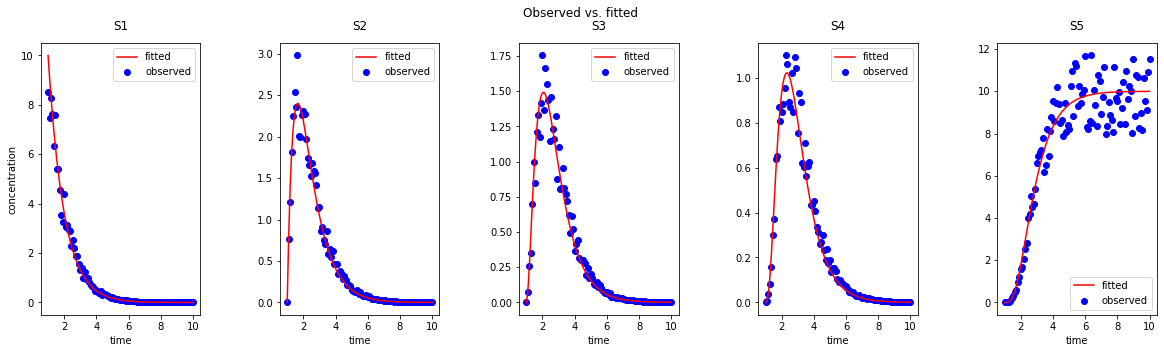

In [17]:
# Fit with Levenberg-Marquardt 
doFit(fitterMethods=["leastsq"])

[[Variables]]
    k1:  1.013534996892992
    k2:  2.1581235094603777
    k3:  3.0793555127592502
    k4:  4.280397620120636
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 1620
    # data points      = 500
    # variables        = 4
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.


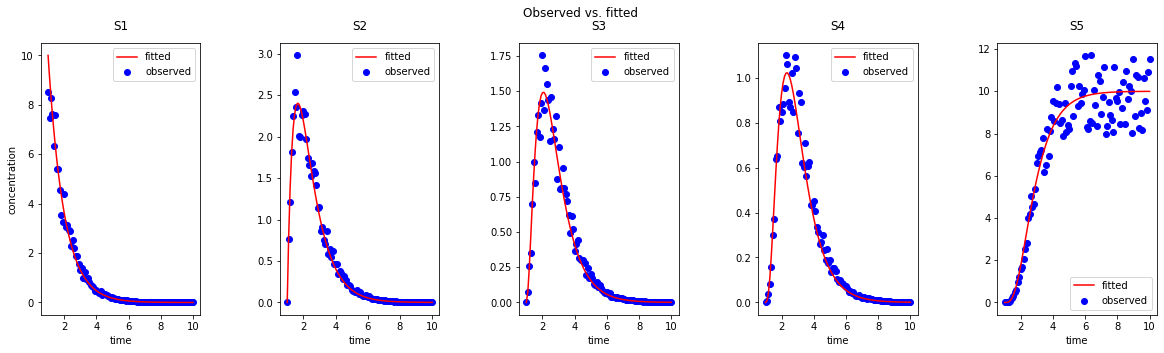

In [18]:
# Fit with differential evolution
doFit(fitterMethods=["differential_evolution"])

[[Variables]]
    k1:  1.013537195758244
    k2:  2.158129615882887
    k3:  3.0793398666367313
    k4:  4.280400943256528
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 500
    # variables        = 4
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


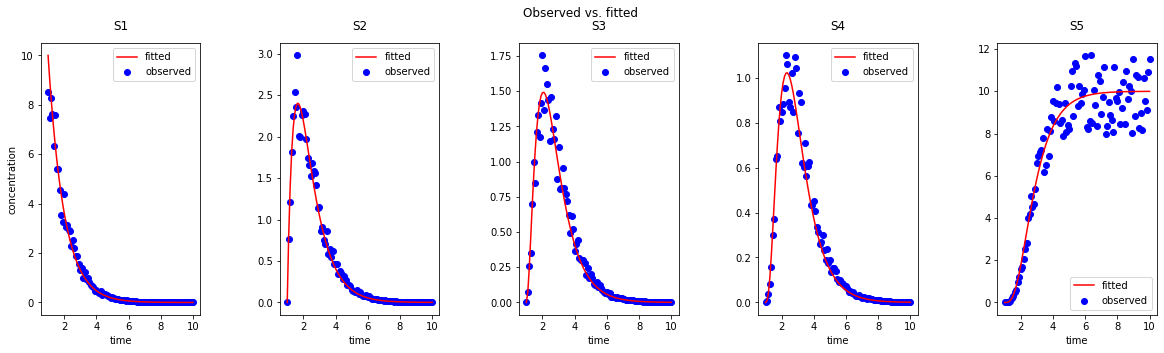

In [19]:
# Fit with differential evolution and then Levenberg-Marquardt 
doFit(fitterMethods=["differential_evolution", "leastsq"])

For this model, we see that Levenberg-Marquardt works better than differential evolution, and doing the two in combination offers no benefit.

## Search Start & Scope

Where we start the search and how far we search depends on the ranges of parameter values and the specification of initial values.
This is specified by the ``parameterDct`` argument to ``ModelFitter``. This argument defaults to ``LINEAR_PATHWAY_PARAMETER_DCT``.

If we create a bad parameter range, then we get very poor fits. Below, we start the search with a negative value for each parameter.
Note that the observed values appear to be constant because of the large scale of the fitted values.

[[Variables]]
    k1:  1.0
    k2:  1.0
    k3:  1.0
    k4:  1.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 4
    chi-square         = 1131.12055
    reduced chi-square = 2.28048498
    Akaike info crit   = 416.177979
    Bayesian info crit = 433.036412
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k4) = -0.821
    C(k3, k4) = -0.462
    C(k2, k4) =  0.239
    C(k1, k2) = -0.207
    C(k1, k3) = -0.128
    C(k2, k3) = -0.123


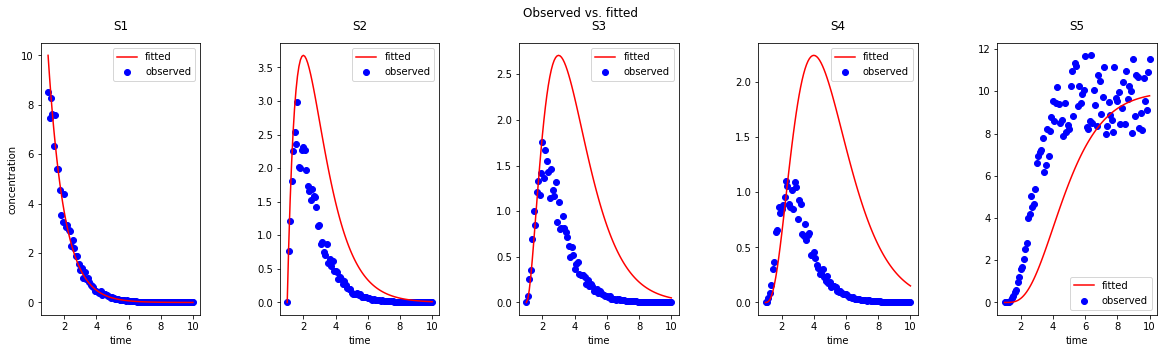

In [20]:
parametersToFit = [
    SBstoat.Parameter("k1", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k2", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k3", lower=-11, value=-1, upper=1),
    SBstoat.Parameter("k4", lower=-11, value=-1, upper=1),
    ]
doFit(parametersToFit=parametersToFit)

# Exercise

This exercise is about fitting parameters in the Wolf model for glycolytic oscillations.
The model is ``WOLF_MODEL`` and the observational data for this model are ``WOLF_DF``.

1. Implement a ``doFit`` function that encapsulates the workflow for the Wolf model.
1. Try fitting the model using ``WOLF_PARAMETERS``. First try ``leastSquares`` (a graident descent method) and then ``differential_evolution``. How did the two methods differ as to fitting time and quality? Why? What would you try next to get better fits?
1. Limit the parameter values so that the upper value is twice the true value. Try fits using leastsqs and differential evolution.